# Using SigGPDE to predict Rainfall
***

To execute this notebook, one should first download the data by doing the following

`cd benchmarks/datasets`

`bash download_weather.sh`

The task we define consists in predicting whether it will rain by more than $1$mm in the next hour, from climatic observations during the previous $6$ hours. 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import sys
sys.path.append('..')

### data loading and processing
from tqdm import tqdm, trange
import pandas as pd
sys.path.append('../benchmarks/utils')
from tslearn_scaler import TimeSeriesScalerMeanVariance

### computations
import numpy as np
import iisignature

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import gpflow as gp
import gpsig

## preprocessing, model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import as_float_array

## plotting
import matplotlib.pyplot as plt
size = 14
import matplotlib.pylab as pylab
params = {'legend.fontsize':16,
          'axes.titlesize' : 24,
          'figure.figsize': (8, 5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize':size,
          'ytick.labelsize':size}
pylab.rcParams.update(params)

## Helper functions

First we define some functions to extract rolling windows of climatic data, and means of the rainfall amount in the future

In [4]:
class AddTime(BaseEstimator, TransformerMixin):
    def __init__(self, init_time=0., total_time=1.):
        self.init_time = init_time
        self.total_time = total_time

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        t = np.linspace(self.init_time, self.init_time + 1, len(X))
        return np.c_[t, X]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

In [5]:
def GetWindow(x, h_window=30, f_window=10):
    # AddTime
    tt = AddTime()

    # First window
    x_ = [tt.transform_instance(x[:h_window,:])]
      
    for i in trange(1,len(x)-h_window+1):
        x_i = x[i:i+h_window,:]
        x_.append(tt.transform_instance(x_i))
    
    return np.stack(x_)[:-f_window,:,:]

def GetNextMean(x, h_window=30, f_window=10):
    cum_rain = x.rolling(f_window).sum().iloc[h_window+f_window-1:,].values
    return cum_rain

Next we define a function to visualize the data

In [6]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    axes[3][1].axis('off')
    plt.tight_layout()

## Data loading

Next we load the climatic data. There are two stations where the data is recorded. We keep the dataframe separate

In [7]:
df_1 = []
for year in range(2004,2021):
    data_a = pd.read_csv('../benchmarks/datasets/weather_data/mpi_roof_{0}a.csv'.format(year),encoding= 'unicode_escape')
    df_1.append(data_a)
    data_b = pd.read_csv('../benchmarks/datasets/weather_data/mpi_roof_{0}b.csv'.format(year),encoding= 'unicode_escape')
    df_1.append(data_b)
df1_ = pd.concat(df_1)

df1_.rename(columns={'SWDR (W/m²)':'SWDR (W/m**2)'}, inplace=True)

df_2 = []
for year in range(2004,2021):
    data_a = pd.read_csv('../benchmarks/datasets/weather_data/mpi_saale_{0}a.csv'.format(year),encoding= 'unicode_escape')
    df_2.append(data_a)
    data_b = pd.read_csv('../benchmarks/datasets/Weather_data/mpi_saale_{0}b.csv'.format(year),encoding= 'unicode_escape')
    df_2.append(data_b)
df2_ = pd.concat(df_2)

We define the channels that we want to keep

In [8]:
titles = [
    "Pressure",
    "Temperature",
    "Relative humidity",
    "Airtight",
    "Wind speed",
    "Soil moisture",
      "Rain"
]

feature_keys = [
 'p (mbar)',
 'T (degC)',
 'rh (%)',
 'rho (g/m**3)',
 'wv (m/s)',
'SWDR (W/m**2)',
 'rain (mm)'
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

We remove the outliers and select the features. 

In [9]:
# remove the obvious outliers
for key in feature_keys:
    df1_[key] = np.where(df1_[key] <= -9998, np.nan, df1_[key])
    df2_[key] = np.where(df2_[key] <= -9998, np.nan, df2_[key]) 

Visualize the time series

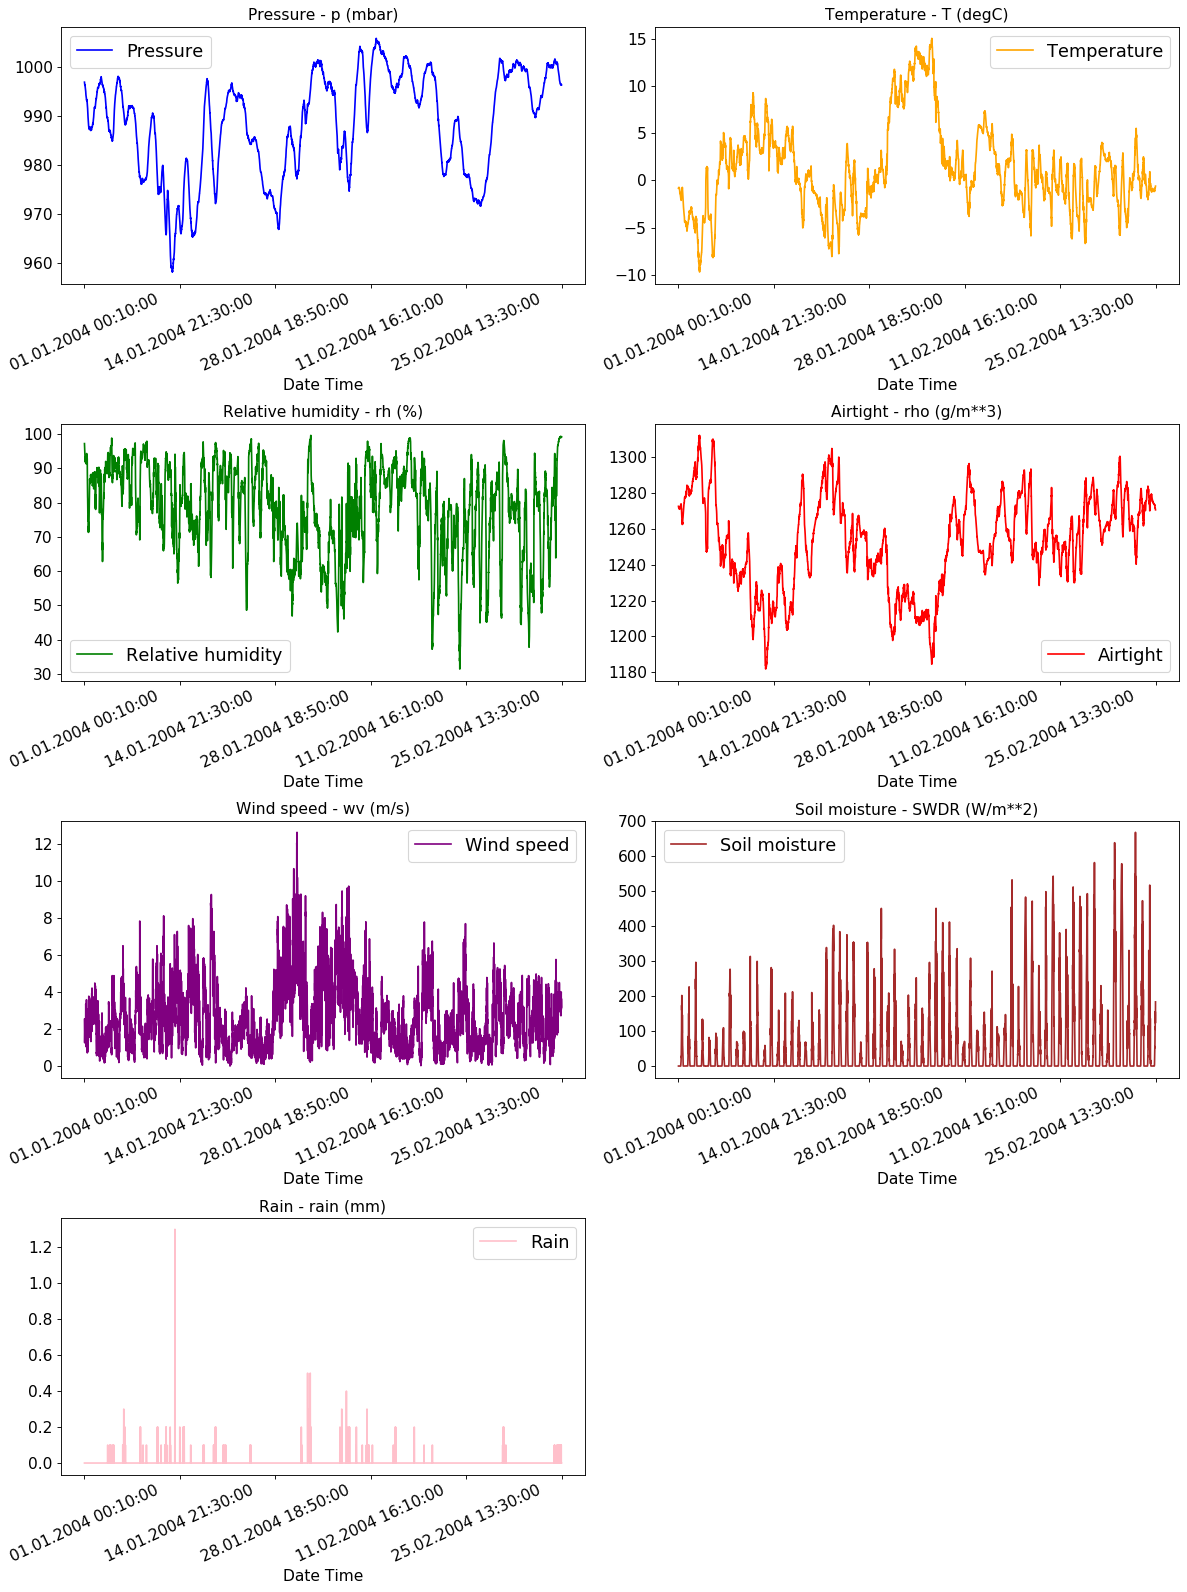

In [10]:
show_raw_visualization(df1_.iloc[:10000])

In [11]:
# select relevant features
df1 = df1_[feature_keys]
df2 = df2_[feature_keys]

df1 = df1.fillna(method='bfill').fillna(method='ffill')
df2 = df2.fillna(method='bfill').fillna(method='ffill')

## Dataset preparation 

Create inputs (outputs) by using the GetWindow (GetNextMean) method, in the two stations

In [12]:
# historic-forward windows specification
h_window = 6*6
f_window = 1*6

In [13]:
# mean rainfall in the next hour
y1 = GetNextMean(df1['rain (mm)'], h_window = h_window , f_window = f_window)
# normal window features
X1_window = GetWindow(df1.values, h_window, f_window)

100%|██████████| 893938/893938 [01:20<00:00, 11163.20it/s]


In [14]:
# mean rainfall in the next hour
y2 = GetNextMean(df2['rain (mm)'], h_window = h_window , f_window = f_window)
# normal window features
X2_window = GetWindow(df2.values, h_window, f_window)

100%|██████████| 892766/892766 [01:12<00:00, 12275.31it/s]


Transform the rain channel

In [15]:
# Instead of keeping the raw rain channel, we consider the cumulative ammount of rain over the previous 6 hours
X1_window[:,:,-1]=np.cumsum(X1_window[:,:,-1],axis=1)
X2_window[:,:,-1]=np.cumsum(X2_window[:,:,-1],axis=1)

Train/Test split using the first station

In [16]:
x_train, x_test, Y_train, Y_test = train_test_split(X1_window[:,:,:], y1, test_size=0.05, shuffle=False)

Add the second station to the train set

In [17]:
x_train = np.concatenate([x_train,X2_window])
Y_train = np.hstack([Y_train,y2])

Create binary labels by setting a positive (negative) label if it rains by more (less) than $1$mm 

In [18]:
y_train = np.zeros(len(Y_train))
y_test = np.zeros(len(Y_test))
y_train[Y_train>1]=1
y_test[Y_test>1]=1

Balance a bit more the dataset

In [19]:
# points for which it is not raining in the next hour
ind_0 = np.arange(len(y_train))[y_train==0]
# points for which it is raining in the next hour
ind_1 = np.arange(len(y_train))[y_train==1]

# indices to be kept in the training set
ind_s = np.random.choice(len(ind_0),3*len(ind_1))

In [20]:
x_train = x_train[np.sort(np.hstack([ind_s,ind_1]))]
y_train = y_train[np.sort(np.hstack([ind_s,ind_1]))]

Train/Val split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False) 
X_test = x_test

Balance the test set (optional)

In [22]:
ind_0 = np.arange(len(y_test))[y_test==0]
ind_1 = np.arange(len(y_test))[y_test==1]

ind_s = np.random.choice(len(ind_0),2*len(ind_1))

In [23]:
X_test = X_test[np.sort(np.hstack([ind_s,ind_1]))]
y_test = y_test[np.sort(np.hstack([ind_s,ind_1]))]

Standard scale the input time series

In [24]:
scaler = TimeSeriesScalerMeanVariance()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Remove the time channel that we added (optional, for the interpretability analysis)

In [25]:
X_train = X_train[:,:,1:]
X_val = X_val[:,:,1:]
X_test = X_test[:,:,1:]

Precompute the signatures for the ELBO

In [26]:
S_train_ = iisignature.sig(X_train,4)
S_val_ = iisignature.sig(X_val,4)
S_test_ = iisignature.sig(X_test,4)

Define the number of inducing variables

In [27]:
M = 1500
S_train = S_train_[:,:M-1]
S_val = S_val_[:,:M-1]
S_test = S_test_[:,:M-1]

Define constants for the GP model

In [28]:
# dataset dimensionality information
num_train, len_examples, num_features = X_train.shape
num_val = X_val.shape[0]
num_test = X_test.shape[0]

# initialize the parameters of the kernel
l_init = gpsig.utils.suggest_initial_lengthscales(X_train, num_samples=2000)

# reshape the data to be compatible with GPFlow
input_dim = len_examples * num_features
X_train = X_train.reshape([-1, input_dim])
X_val = X_val.reshape([-1, input_dim]) if X_val is not None else None
X_test = X_test.reshape([-1, input_dim])

# encode the labels
num_classes = np.unique(y_train).size
labels_dict = {c : i for i, c in enumerate(np.unique(y_train))}
y_train = np.asarray([labels_dict[c] for c in y_train])
y_test = np.asarray([labels_dict[c] for c in y_test])
y_val = np.asarray([labels_dict[c] for c in y_val])

## Define the GP model

In [29]:
order = 3
feat = gpsig.inducing_variables_vosf.UntruncInducingOrthogonalTensors(input_dim=input_dim, d = num_features, M=M)
k = gpsig.kernels_pde.UntruncSignatureKernel(input_dim, num_features, order=order,lengthscales=l_init, implementation='gpu_op')


In [30]:
minibatch_size = 100
if num_classes == 2:
    lik = gp.likelihoods.Bernoulli()
    num_latent = 1
else:
    lik = gp.likelihoods.MultiClass(num_classes)
    num_latent = num_classes

m = gpsig.models.SVGP(np.concatenate([X_train,S_train],axis=1),y_train[:, None], kern=k, feat=feat, whiten=True,likelihood=lik, num_latent=num_latent,minibatch_size=minibatch_size)

In [31]:
def batch_predict_y(m, X, batch_size=None):
    num_iters = int(np.ceil(X.shape[0] / batch_size))
    y_pred = np.zeros((X.shape[0]), dtype=np.float64)
    for i in range(num_iters):
        slice_batch = slice(i*batch_size, np.minimum((i+1)*batch_size, X.shape[0]))
        X_batch = X[slice_batch]
        pred_batch = m.predict_y(X_batch)[0]
        if pred_batch.shape[1] == 1:
            y_pred[slice_batch] = pred_batch.flatten() > 0.5
        else:
            y_pred[slice_batch] = np.argmax(pred_batch, axis=1)
    return y_pred

def batch_predict_density(m, X, y, batch_size=None):
    num_iters = int(np.ceil(X.shape[0] / batch_size))
    y_nlpp = np.zeros((X.shape[0]), dtype=np.float64)
    for i in range(num_iters):
        slice_batch = slice(i*batch_size, np.minimum((i+1)*batch_size, X.shape[0]))
        X_batch = X[slice_batch]
        y_batch = y[slice_batch, None]
        y_nlpp[slice_batch] = m.predict_density(X_batch, y_batch).flatten()
    return y_nlpp

acc = lambda m, X, y: accuracy_score(y,batch_predict_y(m, X, batch_size=minibatch_size))
nlpp = lambda m, X, y: -np.mean(batch_predict_density(m, X, y, batch_size=minibatch_size))

val_acc = lambda m: acc(m, np.concatenate([X_val,S_val],axis=1), y_val)
val_nlpp = lambda m: nlpp(m, np.concatenate([X_val,S_val],axis=1), y_val)

test_acc = lambda m: acc(m, np.concatenate([X_test,S_test],axis=1), y_test)
test_nlpp = lambda m: nlpp(m, np.concatenate([X_test,S_test],axis=1), y_test)

opt = gpsig.training.NadamOptimizer 

We start training the variational parameters and fix the kernel hyperparameters

In [32]:
m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=30000, print_freq=1000, save_freq=1000, val_scorer=[val_acc, val_nlpp])

-------------------------
  Starting optimization  
-------------------------
Iteration 1000	|	Time: 12.58	|	ELBO: -95944.89	|	Val. 0: 0.8321	|	Val. 1: 0.3954
Iteration 2000	|	Time: 30.89	|	ELBO: -105599.76	|	Val. 0: 0.8383	|	Val. 1: 0.3962
Iteration 3000	|	Time: 46.62	|	ELBO: -87848.01	|	Val. 0: 0.8425	|	Val. 1: 0.4025
Iteration 4000	|	Time: 62.48	|	ELBO: -114479.73	|	Val. 0: 0.8440	|	Val. 1: 0.4100
Iteration 5000	|	Time: 78.33	|	ELBO: -100618.95	|	Val. 0: 0.8459	|	Val. 1: 0.4144
Iteration 6000	|	Time: 94.04	|	ELBO: -60407.53	|	Val. 0: 0.8460	|	Val. 1: 0.4195
Iteration 7000	|	Time: 109.66	|	ELBO: -89995.90	|	Val. 0: 0.8480	|	Val. 1: 0.4193
Iteration 8000	|	Time: 125.21	|	ELBO: -88875.70	|	Val. 0: 0.8471	|	Val. 1: 0.4221
Iteration 9000	|	Time: 140.79	|	ELBO: -88206.11	|	Val. 0: 0.8473	|	Val. 1: 0.4230
Iteration 10000	|	Time: 156.41	|	ELBO: -90301.45	|	Val. 0: 0.8486	|	Val. 1: 0.4240
Iteration 11000	|	Time: 171.72	|	ELBO: -67663.74	|	Val. 0: 0.8473	|	Val. 1: 0.4282
Iteration 12000	|	Tim

Next we also train the kernel hyperparameters

In [33]:
m.kern.set_trainable(True)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=30000, print_freq=1000, save_freq=1000, history=hist,
                    val_scorer=[val_acc, val_nlpp], save_best_params=True, lower_is_better=True, patience=5000)
m.assign(hist['best']['params'])

---------------------------
  Continuing optimization  
---------------------------
Iteration 30001	|	Time: 466.35	|	ELBO: -108512.17	|	Val. 0: 0.8491	|	Val. 1: 0.4397
Iteration 31000	|	Time: 494.77	|	ELBO: -79929.05	|	Val. 0: 0.8542	|	Val. 1: 0.4166
Iteration 32000	|	Time: 523.18	|	ELBO: -47197.24	|	Val. 0: 0.8489	|	Val. 1: 0.3924
Iteration 33000	|	Time: 551.61	|	ELBO: -51568.31	|	Val. 0: 0.8453	|	Val. 1: 0.3856
Iteration 34000	|	Time: 579.92	|	ELBO: -36052.16	|	Val. 0: 0.8437	|	Val. 1: 0.3822
Iteration 35000	|	Time: 608.13	|	ELBO: -42736.87	|	Val. 0: 0.8451	|	Val. 1: 0.3798
Iteration 36000	|	Time: 636.28	|	ELBO: -49200.45	|	Val. 0: 0.8456	|	Val. 1: 0.3758
Iteration 37000	|	Time: 664.47	|	ELBO: -37084.91	|	Val. 0: 0.8483	|	Val. 1: 0.3748
Iteration 38000	|	Time: 692.63	|	ELBO: -33141.72	|	Val. 0: 0.8471	|	Val. 1: 0.3728
Iteration 39000	|	Time: 720.81	|	ELBO: -35627.71	|	Val. 0: 0.8481	|	Val. 1: 0.3721
Iteration 40000	|	Time: 749.03	|	ELBO: -27389.82	|	Val. 0: 0.8480	|	Val. 1: 0.3705
It

***
## Results

In [116]:
print('Test nlpp.: {:.03f}'.format(test_nlpp(m)))
print('Test acc.: {:.03f}'.format(test_acc(m)))
print('Test classification report:')
print(classification_report(y_test, np.argmax(m.predict_y(np.concatenate([X_test,S_test],axis=1))[0], axis=1)))

0.8617283950617284

### Visualization of the predictions

First we get back the GP posterior mean and posterior variance on the test set

In [34]:
def batch_predict_f(m, X, batch_size=None,classes=False):
    num_iters = int(np.ceil(X.shape[0] / batch_size))
    y_pred = np.zeros((X.shape[0]), dtype=np.float64)
    conf_pred = np.zeros((X.shape[0]), dtype=np.float64)
    for i in range(num_iters):
        slice_batch = slice(i*batch_size, np.minimum((i+1)*batch_size, X.shape[0]))
        X_batch = X[slice_batch]
        pred_batch, conf_batch = m.predict_y(X_batch)
        if classes:
            y_pred[slice_batch] = pred_batch.flatten()>0.5
        else:
            y_pred[slice_batch] = pred_batch.flatten()
        conf_pred[slice_batch] = conf_batch.flatten()

    return y_pred, conf_pred


g, conf = batch_predict_f(m,  np.concatenate([X_test,S_test],axis=1), batch_size=1000,classes=False)

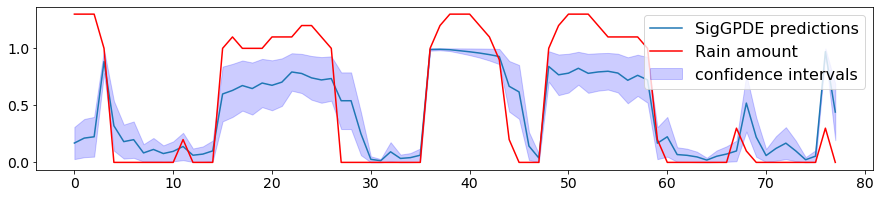

In [35]:
fig = plt.figure(figsize=(15,3))
ax = plt.axes()
start = 32
end = 110

ax.plot(g[start:end],label='SigGPDE predictions')
ax.fill_between(np.arange(end-start),g[start:end]-conf[start:end],g[start:end]+conf[start:end],alpha=0.2,label='confidence intervals',color='b')
ax.plot(Y_test[np.sort(np.hstack([ind_s,ind_1]))][start:end],label='Rain amount',color='red')
plt.legend()
plt.show()

### Interpretability of the signature features

In [36]:
# we rename the features as in the paper
titles = ['Pressure',
 'Temperature',
 'Humidity',
 'Airtight',
 'Wind speed',
 'Moisture',
 'Rain']

In [47]:
q_mu = m.q_mu.value
names = gpsig.utils.get_meaningfull_names_sig_features(num_features,4,titles)[:M]
interpretability = {sig_term:val for sig_term,val in zip(names,np.abs(q_mu[1:,0]))}
df = pd.DataFrame.from_dict(interpretability, orient='index').sort_values(0, ascending=True).iloc[-20:,:]
df.columns = ['feature importance']

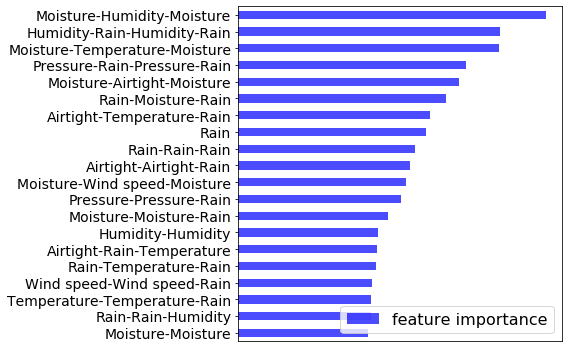

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot(kind='barh', color='blue',alpha=0.7, ax=ax, grid=False)
ax.legend(loc='lower right')
plt.xticks([])
plt.tight_layout()
plt.savefig('feature_importance.pdf')
plt.show()